## Импорт библиотек и функций

In [12]:
pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.3 MB/s eta 0:00:00


In [13]:
pip install optuna-integration -q

In [14]:
pip install optuna -q

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from optuna.integration import OptunaSearchCV
from optuna import distributions
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
import shap
from sklearn.feature_selection import SelectKBest, f_classif

In [16]:
warnings.filterwarnings('ignore')

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Цель работы

1) Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

2) Нужно собрать данные по клиентам по следующим группам:
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.


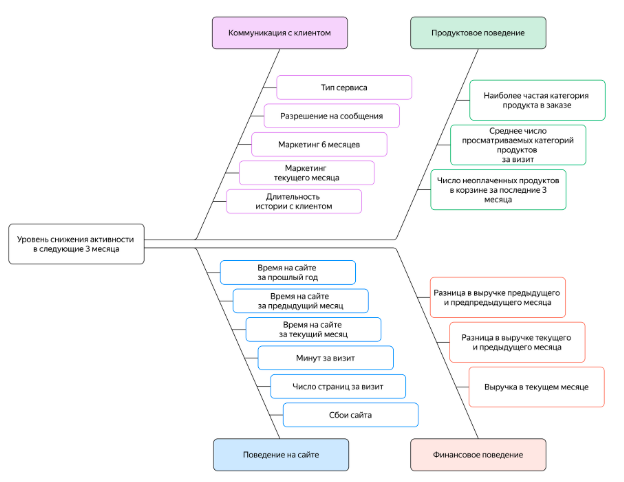

3) Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

4) В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.

5) Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Описание данных

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении`market_file.csv`.

- `id`— номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом `market_money.csv`.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, `'текущий_месяц'` или `'предыдущий_месяц'`.
- `Выручка` — сумма выручки за период.

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода `market_time.csv`.

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю `money.csv`.

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

## Загрузка данных

In [17]:
#для платформы практикума
try:
  market_file = pd.read_csv('/datasets/market_file.csv')
  market_money = pd.read_csv('/datasets/market_money.csv')
  market_time = pd.read_csv('/datasets/market_time.csv')
  money = pd.read_csv('/datasets/money.csv',sep=';')
#для google colab
except:
  market_file = pd.read_csv('/content/market_file.csv')
  market_money = pd.read_csv('/content/market_money.csv')
  market_time = pd.read_csv('/content/market_time.csv')
  money = pd.read_csv('/content/money.csv',sep=';')

In [18]:
market_file.info()
market_file.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
955,216303,Прежний уровень,стандарт,да,4.2,5,624,0.18,Техника для красоты и здоровья,3,1,5,8
716,216064,Прежний уровень,премиум,да,4.3,4,732,0.11,Домашний текстиль,2,4,5,6


In [19]:
market_money.info()
market_money.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
734,215592,предыдущий_месяц,4995.5
2479,216174,текущий_месяц,5040.4


In [20]:
market_time.info()
market_time.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
1745,216220,текущий_месяц,16
1076,215886,текущий_месяц,16


In [21]:
money.info()
money.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


,id,Прибыль
937,216285,"5,18"
817,216165,"7,02"


In [22]:
def tofloat64(series):
    try:
        series = series.apply(lambda x: str(x.replace(',','.')))
        series = series.astype('float64')
    except:
        series
    return series

In [23]:
money['Прибыль'] = tofloat64(money['Прибыль'])

**Выводы по разделу:**
- в money.csv столбцы разделены знаком ";"
- столбец Прибыль в таблицы money имеет неверный тип (object), решено заменить на float
- данные в файлах соответствуют описанию данных

##  Предобработка данных

In [24]:
print('Кол-во явных дубликатов:',market_file.duplicated().sum())

Кол-во явных дубликатов: 0


In [25]:
print('Кол-во дубликатов по id:',market_file.duplicated(subset=['id']).sum())

Кол-во дубликатов по id: 0


In [26]:
print('Кол-во явных дубликатов:',market_money.duplicated().sum())

Кол-во явных дубликатов: 0


In [27]:
print('Кол-во явных дубликатов:',market_time.duplicated().sum())

Кол-во явных дубликатов: 0


In [28]:
print('Кол-во явных дубликатов:',money.duplicated().sum())

Кол-во явных дубликатов: 0


**Выводы по разделу:**

- явных дубликатов и пропусков в данных не обнаружено

## Исследовательский анализ данных

**Анализ market_file:**

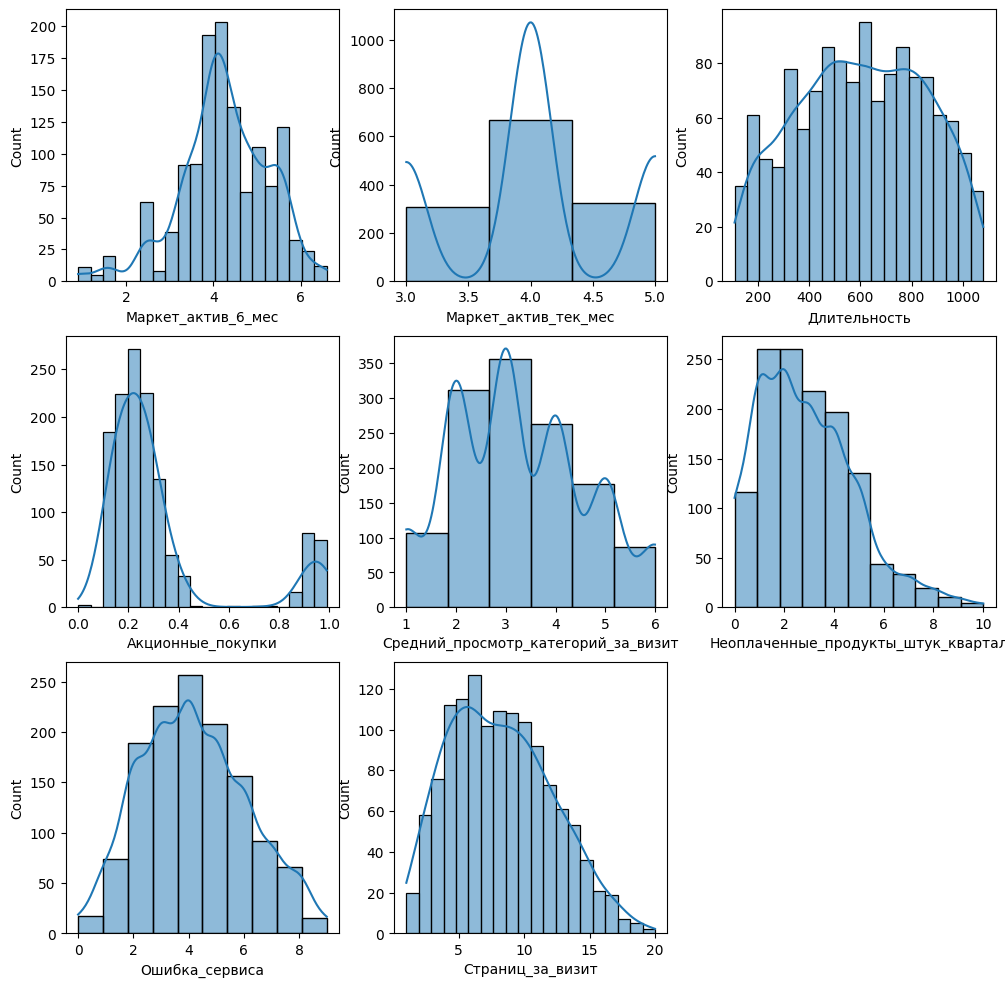

In [29]:
plt.rcParams['figure.figsize'] = [12, 12]
j=0
for i in market_file.drop('id', axis=1).select_dtypes(exclude=[object]).columns:
    j+=1
    plt.subplot(3,3,j)
    t = market_file[i].value_counts().count()
    sns.histplot(market_file[i], bins = t if t<20 else 20, kde=True)

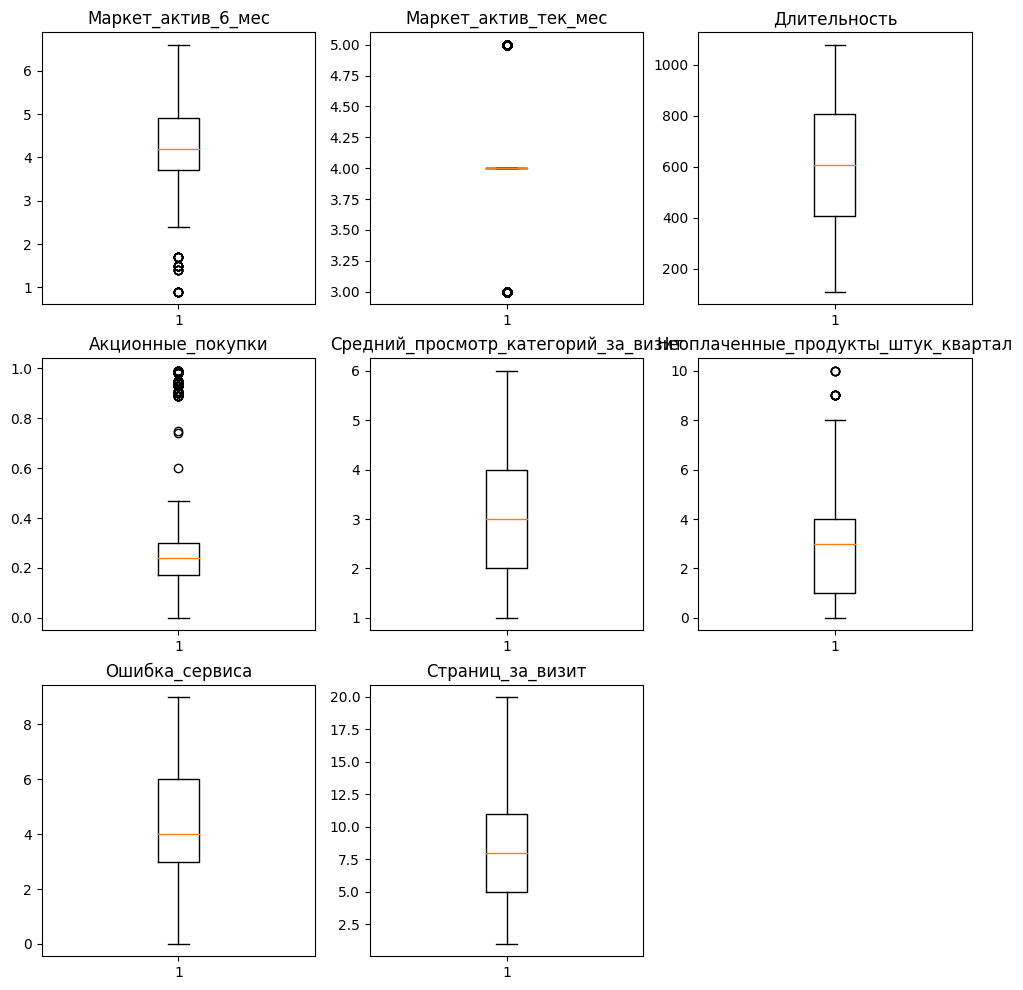

In [30]:
j=0
for i in market_file.drop('id', axis=1).select_dtypes(exclude=[object]).columns:
    j+=1
    plt.subplot(3,3,j)
    plt.boxplot(market_file[i])
    plt.title(i)

In [31]:
market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


- у столбцов 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Средний_просмотр_категорий_за_визит', 'Ошибка_сервиса' наблюдается нормальное распредление
- у столбов 'Неоплаченные_продукты_штук_квартал', 'Страниц_за_визит' наблюдается распределение Пауссона
- у столбца 'Акционные_покупки' наблюдается разделение на 2 категории покупателей: нормальные (доля акционных товаров в среднем 0.24) и покупатели товаров по акции (доля акционных тоаров свыше 0.8)

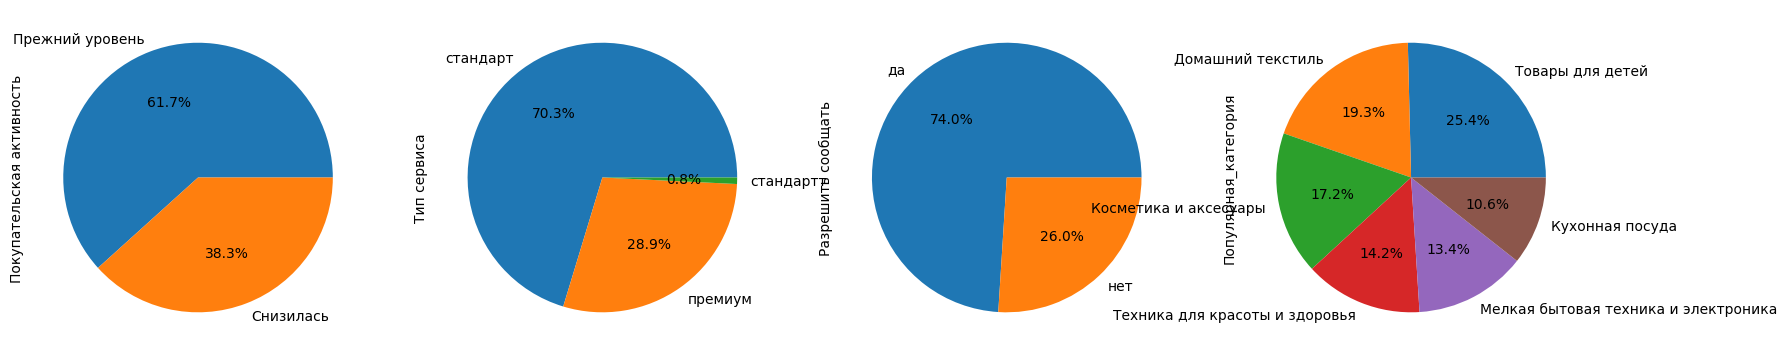

In [32]:
plt.rcParams['figure.figsize'] = [20, 5]
j=0
for i in market_file.select_dtypes(include=[object]).columns:
    j+=1
    plt.subplot(1,4,j)
    market_file[i].value_counts().plot(kind='pie',autopct='%0.1f%%');

- у стобца 'Покупательская_активность' преобладает категория 'Прежний уровень'
- у стобца 'Тип сервиса' преобладает категория 'стандарт'
- у стобца 'Разрешить сообщать' преобладает категория 'Да'
- самая популярная категория товара 'Товары для детей'
- в столбце 'Тип сервиса' найден багрепорт 'стандартт'

In [33]:
market_file.loc[market_file['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'

**Анализ market_money:**

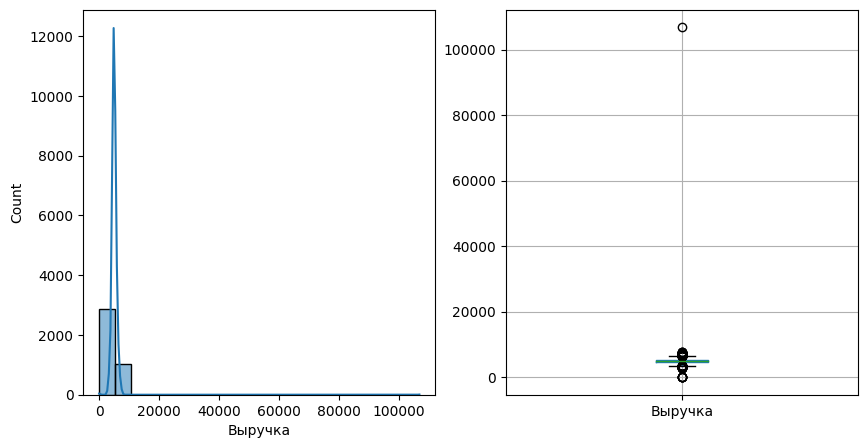

In [34]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,2,1)
sns.histplot(market_money['Выручка'], bins=20, kde=True);
plt.subplot(1,2,2)
market_money.drop('id', axis=1).boxplot();

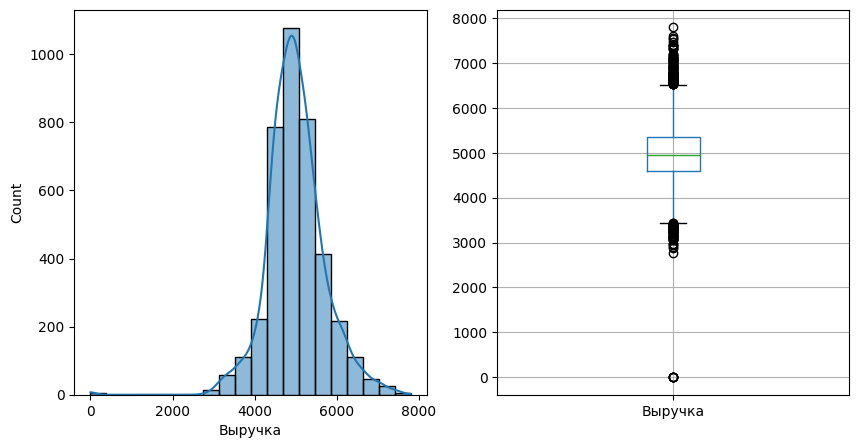

In [35]:
market_money = market_money.loc[market_money['Выручка'] < 10000]
plt.subplot(1,2,1)
sns.histplot(market_money['Выручка'], bins=20, kde=True);
plt.subplot(1,2,2)
market_money.drop('id', axis=1).boxplot();

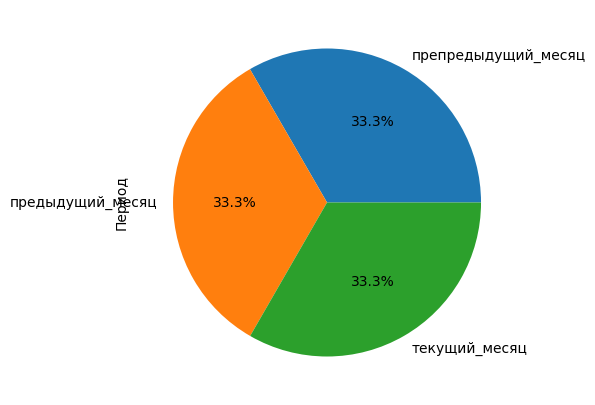

In [36]:
plt.rcParams['figure.figsize'] = [5, 5]
for i in market_money.select_dtypes(include=[object]).columns:
    market_money[i].value_counts().plot(kind='pie',autopct='%0.1f%%');

- в столбце 'Выручка' найдено много выбросов в районе 0, это связано с тем, что некоторых пользоватей в определенный месяц не было совершено покупок
- в столбце 'Выручка' найдено 1 аномальное значение 106862.2, решено его убрать из рассмотрения
- у столбца 'Выручка' наблюдается нормальное распредление
- в столбце 'Период' замечена категория 'препредыдущий_месяц', стоит уточнить у специалиста, что это: багрепорт или граматическая ошибка (предпредыдущий)

In [37]:
market_money.loc[market_money['Период'] == 'препредыдущий_месяц', 'Период'] = 'предпредыдущий_месяц'

**Анализ market_time**

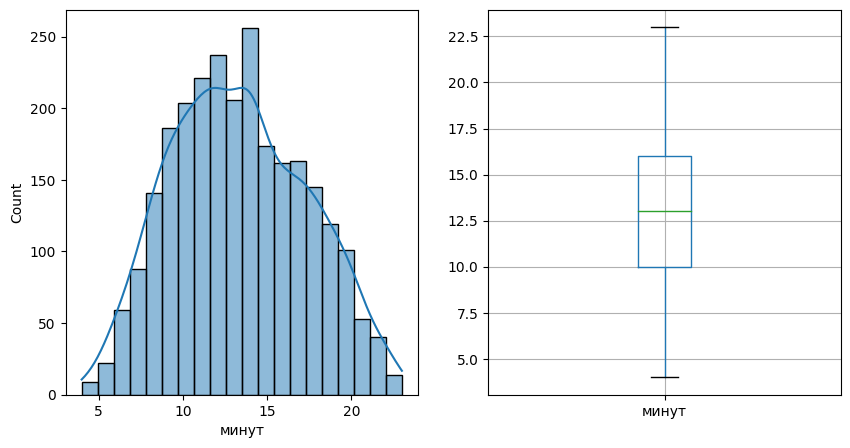

In [38]:
plt.rcParams['figure.figsize'] = [10,5]
plt.subplot(1,2,1)
sns.histplot(market_time['минут'], bins = 20, kde=True)
plt.subplot(1,2,2)
market_time.drop('id', axis=1).boxplot();

In [39]:
market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


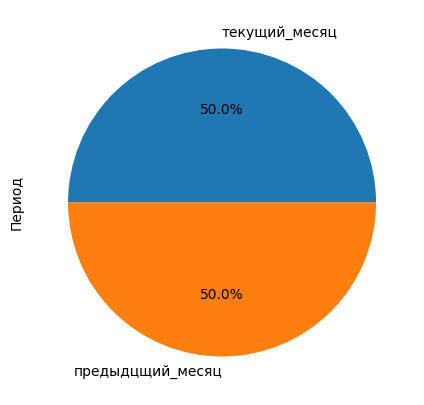

In [40]:
plt.rcParams['figure.figsize'] = [5,5]
market_time['Период'].value_counts().plot(kind='pie',autopct='%0.1f%%');

- у столбца 'минут' наблюдается нормальное распредление
- в столбце 'Период' замечена категория 'предыдцщий_месяц' с граматической ошибкой (предыдущий)
- у стобца 'Период' сбалансированная выборка

In [41]:
market_time.loc[market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'

**Анализ money**

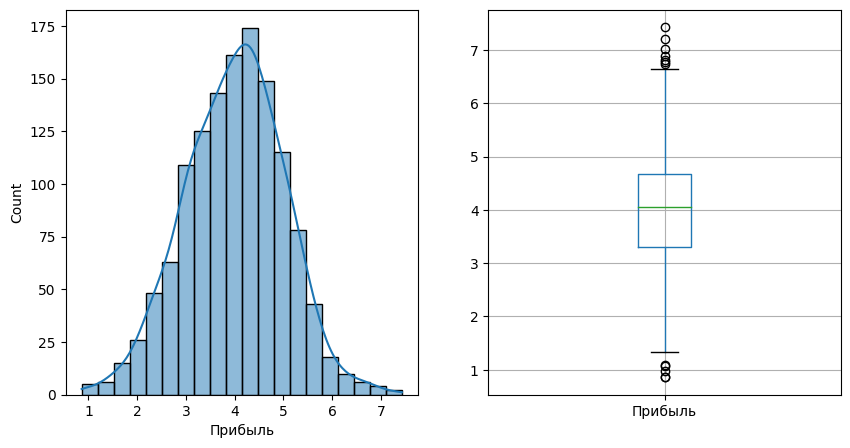

In [42]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,2,1)
sns.histplot(money['Прибыль'], kde=True, bins=20);
plt.subplot(1,2,2)
money.drop('id', axis=1).boxplot();

In [43]:
money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


- у столбца 'Прибыль' наблюдается нормальное распредление

**Выводы по разделу:**

**Анализ market_file**
- у столбцов 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Средний_просмотр_категорий_за_визит', 'Ошибка_сервиса' наблюдается нормальное распредление
- у столбов 'Неоплаченные_продукты_штук_квартал', 'Страниц_за_визит' наблюдается распределение Пауссона
- у столбца 'Акционные_покупки' наблюдается разделение на 2 категории покупателей: нормальные (доля акционных товаров в среднем 0.24) и покупатели товаров по акции (доля акционных тоаров свыше 0.8)
- у стобца 'Покупательская_активность' преобладает категория 'Прежний уровень'
- у стобца 'Тип сервиса' преобладает категория 'стандарт'
- у стобца 'Разрешить сообщать' преобладает категория 'Да'
- самая популярная категория товара 'Товары для детей'
- в столбце 'Тип сервиса' найден багрепорт 'стандартт'

**Анализ market_money:**
- в столбце 'Выручка' найдено много выбросов в районе 0, это связано с тем, что некоторых пользоватей в определенный месяц не было совершено покупок
- в столбце 'Выручка' найдено 1 аномальное значение 106862.2, решено его убрать из рассмотрения
- у столбца 'Выручка' наблюдается нормальное распредление
- в столбце 'Период' замечена категория 'препредыдущий_месяц', стоит уточнить у специалиста, что это: багрепорт или граматическая ошибка (предпредыдущий)

**Анализ market_time**
- у столбца 'минут' наблюдается нормальное распредление
- в столбце 'Период' замечена категория 'предыдцщий_месяц' с граматической ошибкой (предыдущий)
- у стобца 'Период' сбалансированная выборка

**Анализ money**
- у столбца 'Прибыль' наблюдается нормальное распредление


## Объединение таблиц

In [44]:
market_money_pt = market_money.pivot_table(index='id', columns='Период', values='Выручка',aggfunc='sum')
print(market_money_pt.shape)
market_money_pt.sample(3)

(1300, 3)


Период,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц
id,,,
215528,4502.0,5270.0,6103.3
216527,5023.0,4668.0,5106.1
216026,5030.0,4941.5,4994.8


In [45]:
market_money_pt['Покуп_актив_3_мес'] = 'менее_3_мес'
market_money_pt['Покуп_актив_3_мес'] = market_money_pt.loc[(market_money_pt['предпредыдущий_месяц']!=0) & (market_money_pt['предыдущий_месяц']!=0) & (market_money_pt['текущий_месяц']!=0),
                                                           'Покуп_актив_3_мес'] = '3_мес'
market_money_pt['Покуп_актив_3_мес'].value_counts()

3_мес    1300
Name: Покуп_актив_3_мес, dtype: int64

- Все исследуемые пользователи совершали покупки  течении последних 3 месяцев

In [46]:
market_money_pt = market_money_pt.drop(['Покуп_актив_3_мес'], axis=1)
market_time_pt = market_time.pivot_table(index='id', columns='Период', values='минут',aggfunc='sum')
print(market_time_pt.shape)
market_time_pt.sample(3)

(1300, 2)


Период,предыдущий_месяц,текущий_месяц
id,,
215540,9,10
215907,14,11
216502,14,9


In [47]:
market_money_pt.columns = ['Выручка_' + old_column for old_column in market_money_pt.columns]
market_money_pt.columns

Index(['Выручка_предпредыдущий_месяц', 'Выручка_предыдущий_месяц',
       'Выручка_текущий_месяц'],
      dtype='object')

In [48]:
market_time_pt.columns = ['Минут_' + old_column for old_column in market_time_pt.columns]
market_time_pt.columns

Index(['Минут_предыдущий_месяц', 'Минут_текущий_месяц'], dtype='object')

In [49]:
df = market_file
df = df.set_index('id')
df = df.join(market_money_pt, how='inner')
df = df.join(market_time_pt, how='inner')
df.info()
df.sample(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   object 
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит       

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предпредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215703,Снизилась,стандарт,нет,2.4,5,711,0.22,Косметика и аксесуары,2,6,2,6,4831.0,5111.5,5709.5,8,6
215704,Снизилась,стандарт,да,2.4,5,485,0.28,Товары для детей,3,0,3,2,4676.0,3695.0,3926.4,9,12


**Вывод по разделу:**

- загруженные данные исследуемых файлов были объеденены в одну таблицу, для дальнейшего создания модели с этими признаками
- созданы отдельные столбецы для каждого периода по выручке и активности на сайте
- все исследуемые пользователи совершали покупки  течении последних 3 месяцев

## Корреляционный анализ

In [50]:
df['Покупательская активность'] = df['Покупательская активность'].apply(lambda x: 1 if x=='Прежний уровень' else 0)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   int64  
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит       

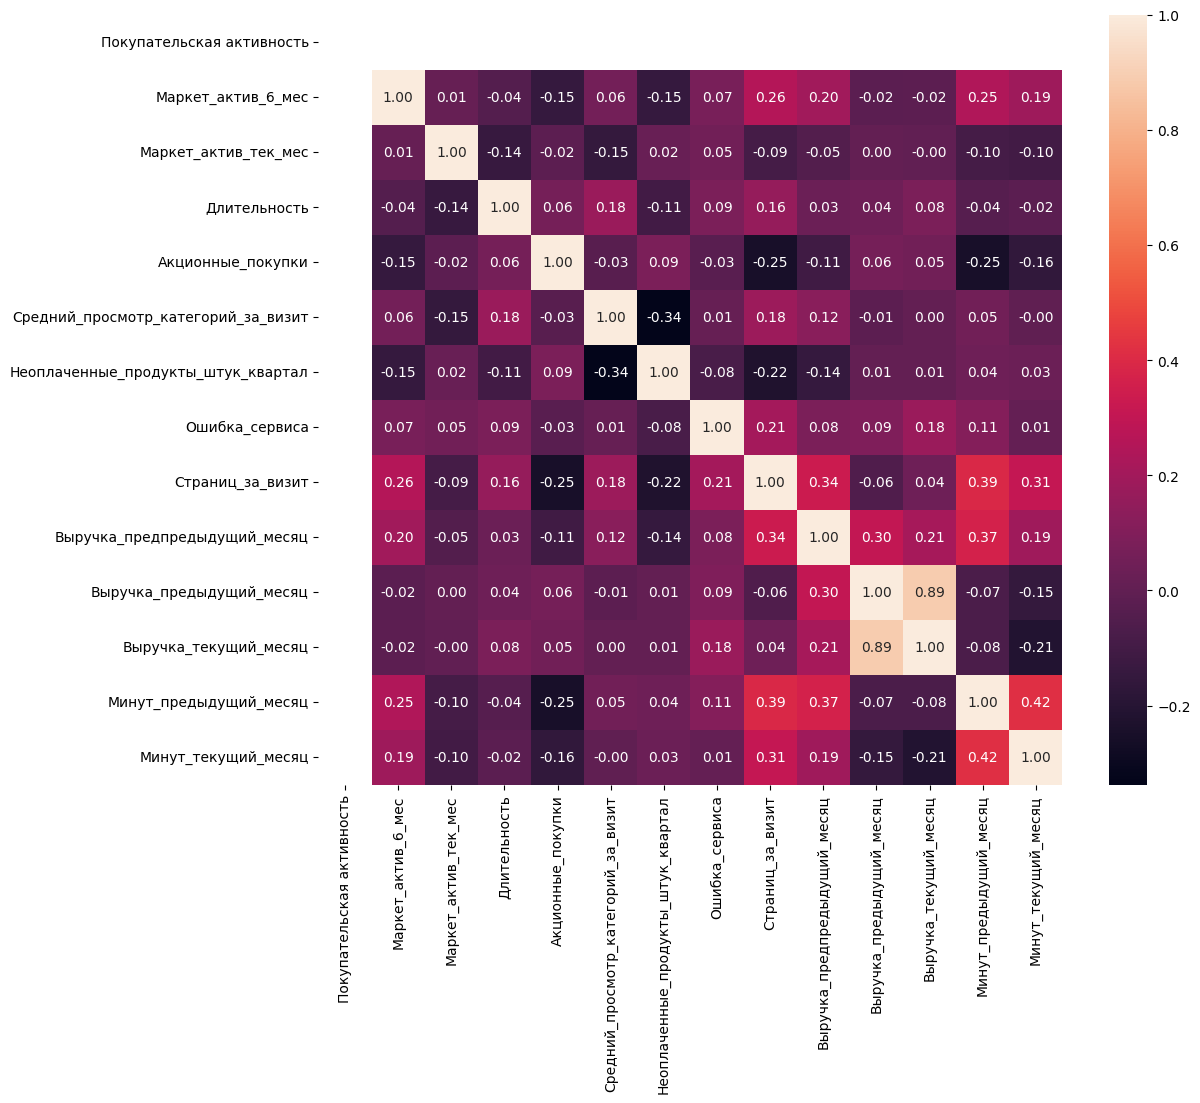

In [52]:
plt.rcParams['figure.figsize'] = [12, 10]
sns.heatmap(df[df['Покупательская активность'] == 0].corr(method='spearman'), annot=True, fmt='.2f');

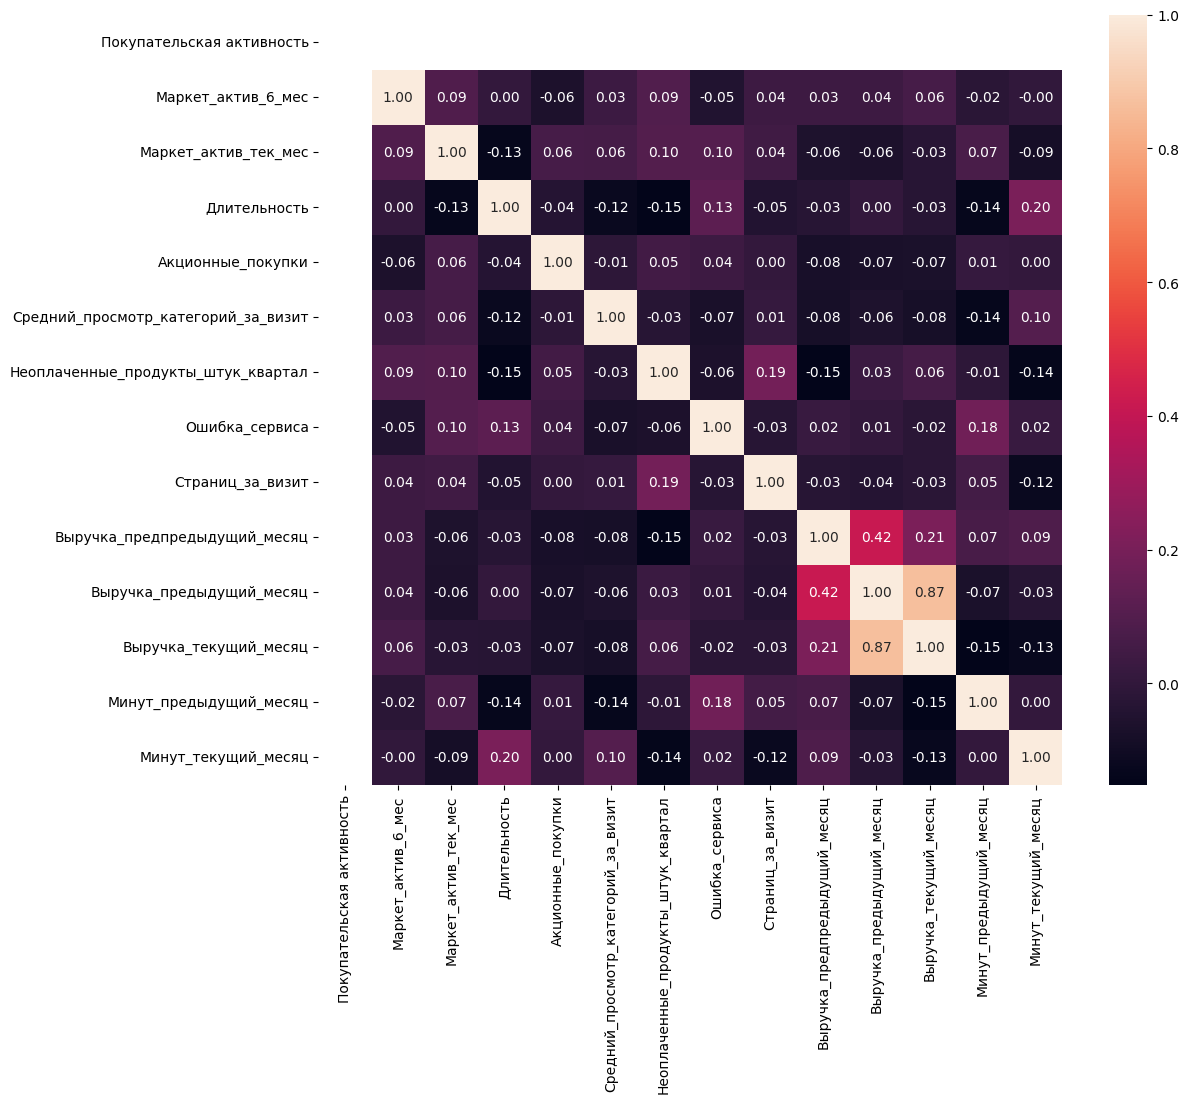

In [53]:
plt.rcParams['figure.figsize'] = [12, 10]
sns.heatmap(df[df['Покупательская активность'] == 1].corr(method='spearman'), annot=True, fmt='.2f');

- наблюдается высокая зависимость между Выручка_предыдущий_месяц от Выручка_текущий_месяц, что приведет к мультиколинеарсности признаков, решено заменить эти два признака на их сумму

In [54]:
df['Выручка_за_последние_2_мес'] = df['Выручка_текущий_месяц'] + df['Выручка_предыдущий_месяц']
df = df.drop(['Выручка_текущий_месяц','Выручка_предыдущий_месяц'], axis=1)
df.columns

Index(['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_предпредыдущий_месяц',
       'Минут_предыдущий_месяц', 'Минут_текущий_месяц',
       'Выручка_за_последние_2_мес'],
      dtype='object')

## Использование пайплайнов

In [55]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 215348 to 216647
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1299 non-null   int64  
 1   Тип сервиса                          1299 non-null   object 
 2   Разрешить сообщать                   1299 non-null   object 
 3   Маркет_актив_6_мес                   1299 non-null   float64
 4   Маркет_актив_тек_мес                 1299 non-null   int64  
 5   Длительность                         1299 non-null   int64  
 6   Акционные_покупки                    1299 non-null   float64
 7   Популярная_категория                 1299 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1299 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 10  Ошибка_сервиса                       1299 non-null   int64  
 11  Страниц_за_визит       

- при разработке модели важно минимизировать ошибки обоих родов, и при исследование используется не сбалансированная выборка,  поэтому будет использоваться метрика ROC-AUC

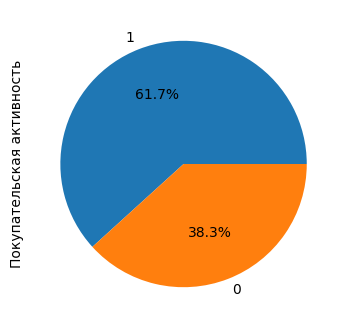

In [56]:
plt.rcParams['figure.figsize'] = [4, 4]
df['Покупательская активность'].value_counts().plot(kind='pie',autopct='%0.1f%%');

In [57]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Покупательская активность'], axis=1),
    df['Покупательская активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['Покупательская активность'])

ohe_columns = ['Тип сервиса','Разрешить сообщать','Популярная_категория']
num_columns = ['Маркет_актив_6_мес','Маркет_актив_тек_мес','Длительность','Акционные_покупки','Средний_просмотр_категорий_за_визит',
              'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса','Страниц_за_визит','Выручка_предпредыдущий_месяц',
               'Выручка_за_последние_2_мес', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц'
              ]

ohe_pipe = Pipeline(
    [('simpleImputer_ohe_before', SimpleImputer(strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)),
     ('simpleImputer_ohe_after', SimpleImputer(strategy='most_frequent'))
    ]
    )
num_pipe = Pipeline(
    [('simpleImputer_num_begore', SimpleImputer(strategy='mean')),
     ('num', StandardScaler()),
     ('simpleImputer_num_after', SimpleImputer(strategy='mean'))
    ]
    )

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ])

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 8),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            class_weight='balanced',
            random_state=RANDOM_STATE,
            solver='liblinear'
        )],
        'models__penalty': ['l1','l2'],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,kernel = 'poly')],
        'models__degree': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]

    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict(X_test)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleImputer_ohe_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Тип сервиса',
                               

In [58]:
result = pd.DataFrame(randomized_search.cv_results_)
print('Лучшие модели:')
print(result[['mean_test_score', 'param_models']].sort_values('mean_test_score', ascending=False))

Лучшие модели:
   mean_test_score                                       param_models
4         0.910775  LogisticRegression(C=2, class_weight='balanced...
2         0.910697  LogisticRegression(C=2, class_weight='balanced...
8         0.852828                             KNeighborsClassifier()
7         0.848246            DecisionTreeClassifier(random_state=42)
5         0.830453            DecisionTreeClassifier(random_state=42)
0         0.823513            DecisionTreeClassifier(random_state=42)
3         0.814600            DecisionTreeClassifier(random_state=42)
9         0.791881            DecisionTreeClassifier(random_state=42)
1         0.782559            DecisionTreeClassifier(random_state=42)
6         0.756165            DecisionTreeClassifier(random_state=42)


- Для более выскоточного подбора гиперпараметров воспользуемся OptunCV

In [61]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Покупательская активность'], axis=1),
    df['Покупательская активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['Покупательская активность'])

ohe_columns = ['Тип сервиса','Разрешить сообщать','Популярная_категория']
num_columns = ['Маркет_актив_6_мес','Маркет_актив_тек_мес','Длительность','Акционные_покупки','Средний_просмотр_категорий_за_визит',
              'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса','Страниц_за_визит','Выручка_предпредыдущий_месяц',
               'Выручка_за_последние_2_мес', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц'
              ]

ohe_pipe = Pipeline(
    [('simpleImputer_ohe_before', SimpleImputer(strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)),
     ('simpleImputer_ohe_after', SimpleImputer(strategy='most_frequent'))
    ]
    )
num_pipe = Pipeline(
    [('simpleImputer_num_begore', SimpleImputer(strategy='mean')),
     ('num', StandardScaler()),
     ('simpleImputer_num_after', SimpleImputer(strategy='mean'))
    ]
    )

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ])

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(
            class_weight='balanced',
            random_state=RANDOM_STATE,
            solver='liblinear',
            max_iter=200
        ))
])

parameters = {
    'models__penalty': distributions.CategoricalDistribution(['l1','l2']),
    'models__C': distributions.IntDistribution(5, 10),
    'preprocessor__num': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
}

oscv = OptunaSearchCV(
    pipe_final,
    parameters,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_trials=20,
    random_state=RANDOM_STATE
)

oscv.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', oscv.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', oscv.best_score_)



# рассчет прогноз на тестовых данных
y_test_pred = oscv.predict(X_test)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

[I 2024-03-24 11:10:18,308] A new study created in memory with name: no-name-bbf1f7bb-7af6-401d-87ee-7f3c31162ef3
[I 2024-03-24 11:10:18,791] Trial 0 finished with value: 0.9106622986622985 and parameters: {'models__penalty': 'l1', 'models__C': 9, 'preprocessor__num': StandardScaler()}. Best is trial 0 with value: 0.9106622986622985.
[I 2024-03-24 11:10:19,480] Trial 1 finished with value: 0.9106414042141315 and parameters: {'models__penalty': 'l1', 'models__C': 5, 'preprocessor__num': 'passthrough'}. Best is trial 0 with value: 0.9106622986622985.
[I 2024-03-24 11:10:19,875] Trial 2 finished with value: 0.9106392897029261 and parameters: {'models__penalty': 'l1', 'models__C': 10, 'preprocessor__num': MinMaxScaler()}. Best is trial 0 with value: 0.9106622986622985.
[I 2024-03-24 11:10:20,370] Trial 4 finished with value: 0.9106624128260492 and parameters: {'models__penalty': 'l1', 'models__C': 8, 'preprocessor__num': StandardScaler()}. Best is trial 4 with value: 0.9106624128260492.
[I

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('simpleImputer_ohe_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Тип сервиса',
                               

- Наилучшие показания метрики показывает модель Логистической регрессии с следующеми гиперпараметрами (C=5, class_weight='balanced', max_iter=200,penalty='l1',solver='liblinear')
- Наблюдается снижение метрики на тестовой выборке, это может говорить о переобученности модели, необходимо провести анализ важности признаков)

## Анализ важности признаков

- Для улучшения модели добавим полиномные признаки и оценим вклад этих признаков на модель

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Покупательская активность'], axis=1),
    df['Покупательская активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['Покупательская активность'])
# Масштабирование количественных признаков для тренировочной и тестовой выборок с помощью стандартизации
scaler = MinMaxScaler()
poly = PolynomialFeatures(2)
X_train_scaled = poly.fit_transform(X_train[num_columns])
X_test_scaled = poly.transform(X_test[num_columns])
X_test_df = pd.DataFrame(X_test_scaled,columns = poly.get_feature_names_out())
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled),columns = poly.get_feature_names_out())
X_test_scaled =  pd.DataFrame(scaler.transform(X_test_scaled),columns = poly.get_feature_names_out())

# Кодирование критериальных признаков
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

# Объединение масштабированных и кодированных признаков
encoder_col_names = encoder.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# Обучение модели
model = LogisticRegression(C=5, class_weight='balanced', max_iter=200,penalty='l1',solver='liblinear', random_state=42)
model = model.fit(X_train, y_train)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, model.predict(X_test))}')

Метрика ROC-AUC на тестовой выборке: 0.8432635211041566


- Добавление полиномных признаков позволило улучшить метрику на 1,7%

In [66]:
num_columns_df= pd.DataFrame(num_columns)
num_columns_df

,0
0,Маркет_актив_6_мес
1,Маркет_актив_тек_мес
2,Длительность
3,Акционные_покупки
4,Средний_просмотр_категорий_за_визит
5,Неоплаченные_продукты_штук_квартал
6,Ошибка_сервиса
7,Страниц_за_визит
8,Выручка_предпредыдущий_месяц
9,Выручка_за_последние_2_мес


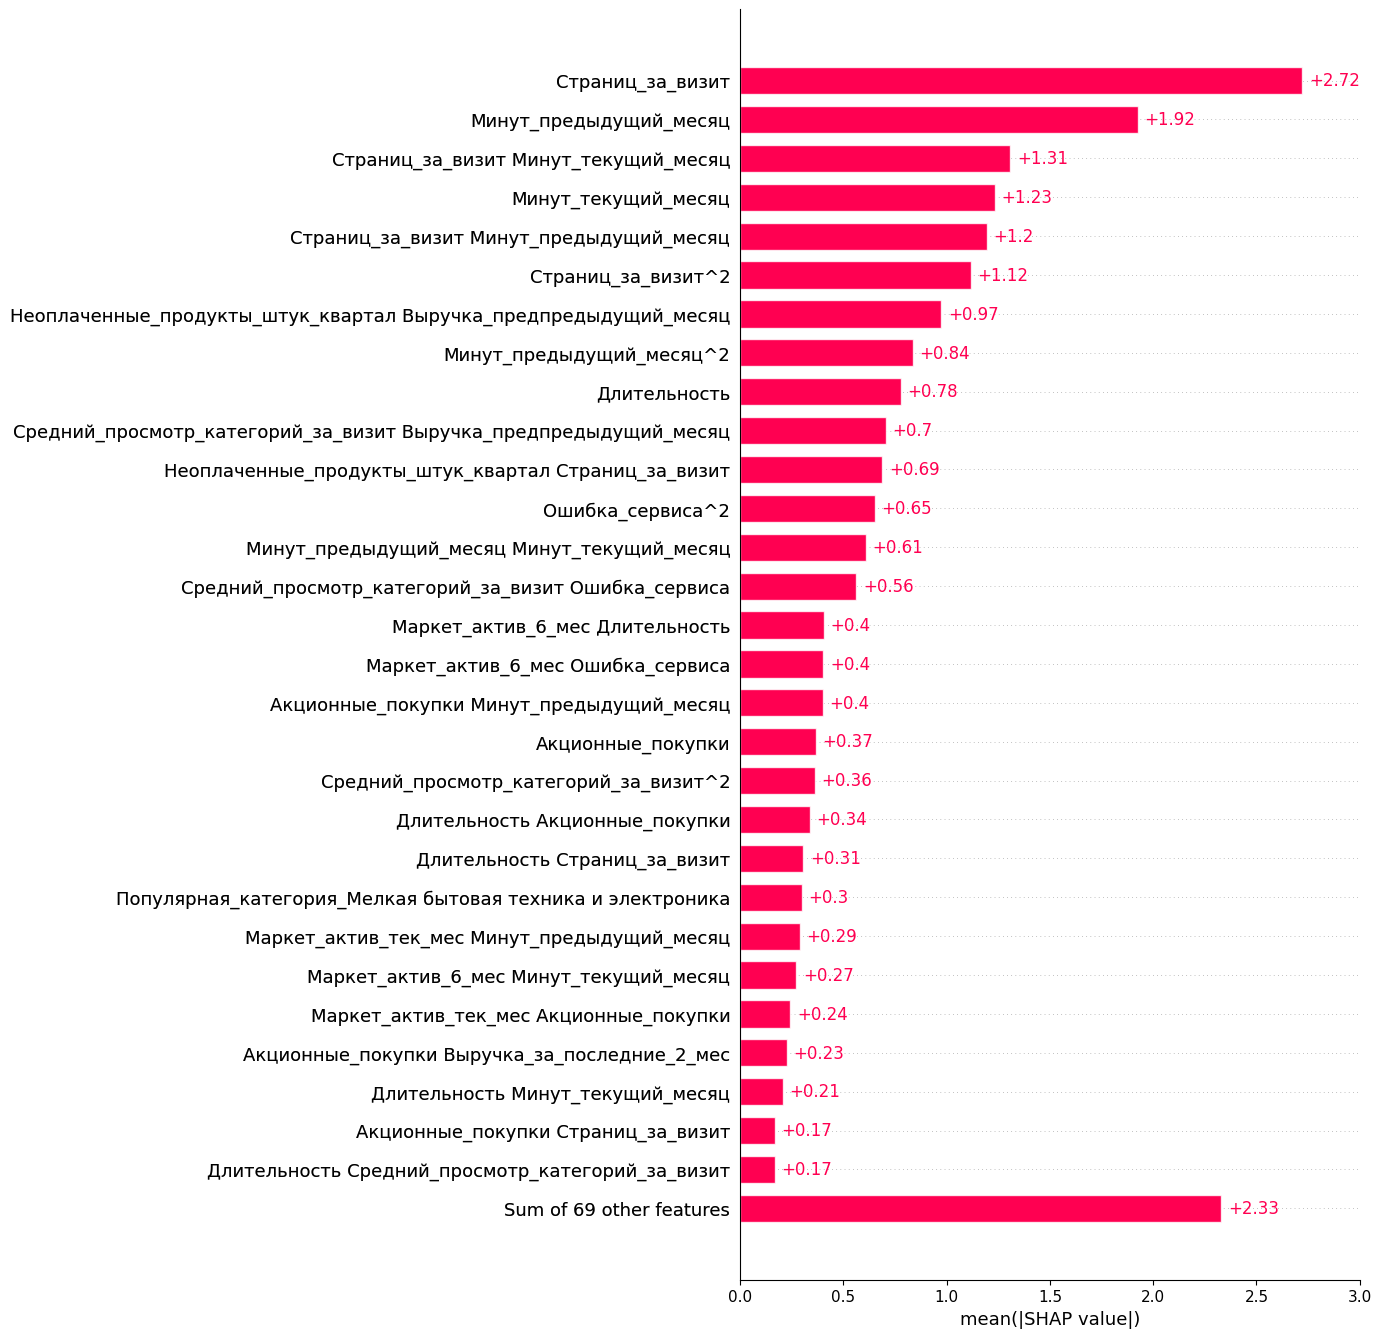

In [68]:
plt.rcParams['figure.figsize'] = [2, 2]
explainer = shap.LinearExplainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=30)

In [70]:
roc = []

for i in range(len(X_test.columns)):
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train, y_train)

    # сохраняем названия признаков в переменную features_names
    features_names = selector.get_feature_names_out()

    # стандартизируем признаки
    X_train_new = X_train[list(features_names)]
    X_test_new = X_test[list(features_names)]

    # инициализируем и обучаем модель
    model = LogisticRegression(C=5, class_weight='balanced', max_iter=200,penalty='l1',solver='liblinear', random_state=42)
    model.fit(X_train_new, y_train)

    roc=roc_auc_score(y_test, model.predict(X_test_new))

    print('Кол-во признаков:', i+1, 'Метрика ROC-AUC на тестовой выборке: ',roc)

Кол-во признаков: 1 Метрика ROC-AUC на тестовой выборке:  0.7239407799711122
Кол-во признаков: 2 Метрика ROC-AUC на тестовой выборке:  0.7481343283582089
Кол-во признаков: 3 Метрика ROC-AUC на тестовой выборке:  0.7835620285668432
Кол-во признаков: 4 Метрика ROC-AUC на тестовой выборке:  0.7885371529449525
Кол-во признаков: 5 Метрика ROC-AUC на тестовой выборке:  0.807494784143797
Кол-во признаков: 6 Метрика ROC-AUC на тестовой выборке:  0.8115270422083132
Кол-во признаков: 7 Метрика ROC-AUC на тестовой выборке:  0.8059500882683357
Кол-во признаков: 8 Метрика ROC-AUC на тестовой выборке:  0.8093805167709838
Кол-во признаков: 9 Метрика ROC-AUC на тестовой выборке:  0.8053482587064676
Кол-во признаков: 10 Метрика ROC-AUC на тестовой выборке:  0.8103233830845772
Кол-во признаков: 11 Метрика ROC-AUC на тестовой выборке:  0.8103233830845772
Кол-во признаков: 12 Метрика ROC-AUC на тестовой выборке:  0.809721553522709
Кол-во признаков: 13 Метрика ROC-AUC на тестовой выборке:  0.81469667790081

- Наилучшие показания метрики можно достичь при использовании 94 признаков из 98 используемых в модели
- Наиболее важными признаками для оценки покупательской активности оказались признаки характеризующие Поведение на сайте (Страниц_за_визит, Минут_текущий_мес, Минут_предыдущий_мес)

## Сегментация покупателей

- Для поддержания покупательской активности клиентов рекомендуется проводить мероприятия по удержанию пользователей на сайте "В один клик"
- Для удержания пользователей рекомендуются использовать промо-акции для клиентов предсказанных разработанной моделью
- Так для покупателей с долей акционных товаров свыше 0.8 (см. Исследовательский анализ) и предсказанным снижением покупательской активности рекомендуется присылать список акционных товаров на текущий момент или купоны на скидку на определенны товары
- Для покупателей в списке покупок которых товар из группы техники свыше 13% (см. Исследовательский анализ) рекомендуется в первой строчке предложенных товаров указывать товары из техники, подобную стратегию также рекомендуется использовать для покупателей у которых «Товары для себя» превышают 14%


## Общий вывод

В данной работе разработана модель, которая предсказывает вероятность снижения покупательской активности.

Данные были получены из следующих файлов /datasets/market_file.csv, /datasets/market_money.csv, /datasets/market_time.csv, /datasets/money.csv. Перед началом исследовательской части был произведен обзор и проверка на адекватность полученных данных. Выявлено, что:

- в money.csv столбцы разделены знаком ";"
- столбец Прибыль в таблицы money имеет неверный тип (object), решено заменить на float
- данные в файлах соответствуют описанию данных

Перед началом исследования была проведена предобработка данных,в рамках которой выялено:

- явных дубликатов и пропусков в данных не обнаружено

В ходе исследования данных выявлены следующие особенности:

**Анализ market_file**
- у столбцов 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Средний_просмотр_категорий_за_визит', 'Ошибка_сервиса' наблюдается нормальное распредление
- у столбов 'Неоплаченные_продукты_штук_квартал', 'Страниц_за_визит' наблюдается распределение Пауссона
- у столбца 'Акционные_покупки' наблюдается разделение на 2 категории покупателей: нормальные (доля акционных товаров в среднем 0.24) и покупатели товаров по акции (доля акционных тоаров свыше 0.8)
- у стобца 'Покупательская_активность' преобладает категория 'Прежний уровень'
- у стобца 'Тип сервиса' преобладает категория 'стандарт'
- у стобца 'Разрешить сообщать' преобладает категория 'Да'
- самая популярная категория товара 'Товары для детей'
- в столбце 'Тип сервиса' найден багрепорт 'стандартт'

**Анализ market_money:**
- в столбце 'Выручка' найдено много выбросов в районе 0, это связано с тем, что некоторых пользоватей в определенный месяц не было совершено покупок
- в столбце 'Выручка' найдено 1 аномальное значение 106862.2, решено его убрать из рассмотрения
- у столбца 'Выручка' наблюдается нормальное распредление
- в столбце 'Период' замечена категория 'препредыдущий_месяц', стоит уточнить у специалиста, что это: багрепорт или граматическая ошибка (предпредыдущий)

**Анализ market_time**
- у столбца 'минут' наблюдается нормальное распредление
- в столбце 'Период' замечена категория 'предыдцщий_месяц' с граматической ошибкой (предыдущий)
- у стобца 'Период' сбалансированная выборка

**Анализ money**
- у столбца 'Прибыль' наблюдается нормальное распредление

Для разработки модели все исследуемые данные были сведены в одну таблицу:

- загруженные данные исследуемых файлов были объеденены в одну таблицу, для дальнейшего создания модели с этими признаками
- созданы отдельные столбецы для каждого периода по выручке и активности на сайте
- все исследуемые пользователи совершали покупки  течении последних 3 месяцев

Для предотвращения мультиколиерности признаков, был проведен корреляционный анализ, который показал:

- наблюдается высокая зависимость между Выручка_предыдущий_месяц от Выручка_текущий_месяц, что приведет к мультиколинеарсности признаков, решено заменить эти два признака на их сумму

Для автоматизации подбора гиперпараметров при разработки модели был использован пайплан, в рамках которого:

- при разработке модели важно минимизировать ошибки обоих родов, и при исследование используется не сбалансированная выборка,  поэтому будет использоваться метрика ROC-AUC
- для оптимазиции времени расчета первые варианты модели с расширенным списком гиперпараметров были проверены благодаря RandomizedSearchCV, а более точные варинты гиперпараметров уже были получены с использованием OptunaSearchCV
- наилучшие показания метрики показывает модель Логистической регрессии с следующеми гиперпараметрами (C=5, class_weight='balanced', max_iter=200,penalty='l1',solver='liblinear')
- наблюдается снижение метрики на тестовой выборке, это может говорить о переобученности модели, необходимо провести анализ важности признаков)

Для улучшения метрики модели был проведен анализ важности признаков, в рамках которого:

- Добавление полиномных признаков позволило улучшить метрику на 1,7%
- Наилучшие показания метрики можно достичь при использовании 94 признаков из 98 используемых в модели
- Наиболее важными признаками для оценки покупательской активности оказались признаки характеризующие Поведение на сайте (Страниц_за_визит, Минут_текущий_мес, Минут_предыдущий_мес)

По полученным ранее исследовательскому анализу и подготовленной модели была проведена сегментация покупателей и предлождены рекомендации по улучшению бизнеса:

- Для поддержания покупательской активности клиентов рекомендуется проводить мероприятия по удержанию пользователей на сайте "В один клик"
- Для удержания пользователей рекомендуются использовать промо-акции для клиентов предсказанных разработанной моделью
- Так для покупателей с долей акционных товаров свыше 0.8 (см. Исследовательский анализ) и предсказанным снижением покупательской активности рекомендуется присылать список акционных товаров на текущий момент или купоны на скидку на определенны товары
- Для покупателей в списке покупок которых товар из группы техники свыше 13% (см. Исследовательский анализ) рекомендуется в первой строчке предложенных товаров указывать товары из техники, подобную стратегию также рекомендуется использовать для покупателей у которых «Товары для себя» превышают 14%





